# Markov Random Geometric Graph (MRGG):
# A Growth Model for Temporal Dynamic Networks


## Quentin Duchemin \& Yohann De Castro


In [48]:
from MRGG.Graph import Graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import os

# 1) Basic applications of the algorithm on simulated data

In [6]:
n = 1000
dimension = 3
G = Graph(n,dimension, sampling_type='markov',enveloppe='heaviside',latitude='mixture', sparsity = 1)
G.SCCHEi_with_R_search()

### Visualization of the envelope and latitude functions

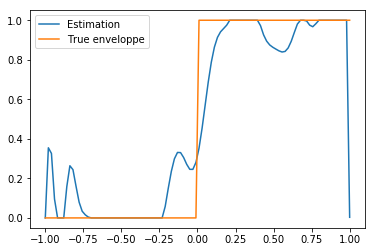

In [7]:
G.plot_estimation_enveloppe()

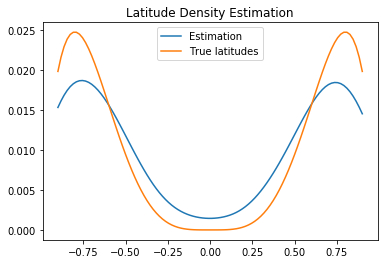

In [17]:
G.plot_densities_latitude()

### Clustering of the eigenvalues of the adjacency matrix

We plot the eigenvalues of the adjacency matrix of the graph with colors corresponding to clusters built by our algorithm SCCHEi.

In [ ]:
G.plot_eigenvalues_clusters_labeled(5)

In the following figure, we plot the eigenvalues $(p^*_k)_{k \geq 0}$ of the true envelope function $p$ and $(\hat{p}_k)_{k \geq 0}$ of the estimated envelope function (without multiplicity).

In [ ]:
G.plot_comparison_eig_envelope()

In the following, we plot the eigenvalues of the adjacency matrix sorted in decreasing order of magnitude with blue crosses, while red diamonds present the spectrum $(\hat{p}_k)_{k \geq 0}$ built using the algorithm SCCHEi.

In [ ]:
G.plot_adjacency_eigs_vs_SCCHEi_clusters(8)

# 2) Studying the performance of the algorithm with a size increasing

In [46]:
def study_error(latitude,enveloppe):
    d = 3
    results  = {'error_enveloppe':[],'error_latitude':[],'size':[]}
    listen = list(map(int,np.logspace(np.log10(20),np.log10(1000),20)))
    for n in listen:
        for _ in range(7):
            G = Graph(n, d, sampling_type = 'markov', latitude = latitude, enveloppe = enveloppe)
            G.SCCHEi_with_R_search()
            results['error_enveloppe'].append(G.error_estimation_enveloppe())
            results['error_latitude'].append(G.error_estimation_latitude())
            results['size'].append(n)
    df = pd.DataFrame(results)
    df = df.apply(np.log10)
    return df

import seaborn as sns
def plot_errors(dataframe):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121)
    sns.lineplot(x="size", y="error_enveloppe", err_style="bars", data=dataframe, ax = ax, label='Envelope')
    ax.set_xlabel('$\log \;n$', fontsize=16)
    ax.set_ylabel('$\log \;\delta_2(p^*,\hat{p})$', fontsize=16)
    ax.set_title('Estimation Error Envelope function', fontsize=16)
    plt.legend(fontsize=16)
    ax = fig.add_subplot(122)
    c = sns.lineplot(x="size", y="error_latitude", err_style="bars", data=dataframe, ax = ax, label='Latitude')
    c.lines[0].set_linestyle("--")
    ax.set_xlabel('$\log \; n$', fontsize=16)
    ax.set_ylabel('$\log \; \delta_2(f^*,\hat{f})$', fontsize=16)
    ax.set_title('Estimation Error Latitude function', fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

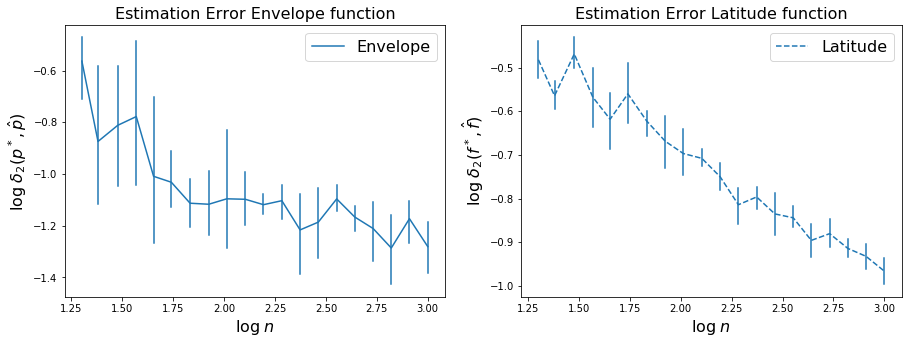

In [47]:
import pickle
df = study_error('mixture', 'heaviside')
plot_errors(df)

# 3) Application on real data


###### You can download the data at  https://snap.stanford.edu/data/loc-gowalla.html
###### You should create a folder named *data* and save the files from the above links inside.

### a) With underlying Markovian dynamic


###### You should launch the following part of code on a cluster to modify the data to build the graph.

In [ ]:
######## Saving friendships between users
edges = []
ID2friends = {}
with open('data/Gowalla_edges.txt') as f:
    content = f.readlines()
    fist = True
    for line in content:
        l = line.split('\t')
        edges.append([int(l[0]),int(l[1][:-1])])
        if int(l[0]) in ID2friends.keys():
            ID2friends[int(l[0])].append(int(l[1][:-1]))
        else:
            ID2friends[int(l[0])] = [int(l[1][:-1])]
        if int(l[1][:-1]) in ID2friends.keys():
            ID2friends[int(l[1][:-1])].append(int(l[0]))
        else:
            ID2friends[int(l[1][:-1])] = [int(l[0])]  
edges = np.array(edges)

######## Saving Check-ins user/timestamp
import datetime as date   
checkin = []
ID2firstCI = { key:np.float('inf') for key in ID2friends.keys() }
with open('data/Gowalla_totalCheckins.txt') as f:
    content = f.readlines()
    for line in content:
        l = line.split('\t')[:2]
        timeformat = date.datetime.strptime(l[1][:-1],"%Y-%m-%dT%H:%M:%S")
        li = [int(l[0]),date.datetime.timestamp(timeformat)]
        checkin.append(li)
        ID2firstCI[li[0]] = min(li[1],ID2firstCI[li[0]])

checkin = np.array(checkin)
checkin = checkin[np.argsort(checkin[:,1]),:]


######## Ordering the user using a self-avoiding random walk
MarkovChain = []
IDseen = {key:False for key in ID2friends.keys()}
np.random.seed(3)
state = min(ID2firstCI.items(), key=lambda x: x[1])[0]
IDseen[state] = True
MarkovChain.append(state)
n = len(list(IDseen))
count = 1
while count <= n-1:
    available_friends = list(filter(lambda x:not(IDseen[x]),ID2friends[state]))
    if len(available_friends) == 0:
        states = list(filter(lambda x:not(IDseen[x]),list(IDseen.keys())))
        dico = {ID:ID2firstCI[ID] for ID in states}
        state = min(dico.items(), key=lambda x: x[1])[0]
    else:
        dico = {ID:ID2firstCI[ID] for ID in available_friends}
        state = min(dico.items(), key=lambda x: x[1])[0]
    IDseen[state] = True
    count += 1
    MarkovChain.append(state)

MarkovChain = np.array(MarkovChain)
np.save('data/MarkovChain.npy', MarkovChain)


######## Data for the adjacency matrix
ID2pos = {}
for i,ID in enumerate(MarkovChain):
    ID2pos[ID] = i
n = len(MarkovChain)
rows = []
cols = []
data = []
for k in range(edges.shape[0]):
    try:
        i,j = ID2pos[edges[k,0]], ID2pos[edges[k,1]]
        rows.append(i)
        rows.append(j)
        cols.append(j)
        cols.append(i)
        data.append(1.0)
        data.append(1.0)
    except:
        pass

rows = np.array(rows)
cols = np.array(cols)
data = np.array(data)
np.save('data/rows.npy',rows)
np.save('data/cols.npy',cols)
np.save('data/data.npy',data)
np.save('data/edges-yo.npy',edges)
import pickle
f = open("data/ID2friends.pkl","wb")
pickle.dump(ID2friends,f)
f.close()
f = open("data/ID2firstCI.pkl","wb")
pickle.dump(ID2firstCI,f)
f.close()

###### Once data are saved, you can run the following locally

In [ ]:
MarkovChain = np.load('data/MarkovChain.npy')
rows = np.load('data/rows.npy')
data = np.load('data/data.npy')
cols = np.load('data/cols.npy')

In [ ]:
nbeigvals = 100
A = sc.sparse.coo_matrix((data, (rows, cols)))
eig, vec = sc.sparse.linalg.eigsh(A, k=nbeigvals, which='LM')
dimension = 2
G = Graph(2*nbeigvals,dimension)
G.dec_eigs= eig[::-1]
G.SCCHEi_with_R_search()

###### Clustering eigenvalues

In [ ]:
G.plot_adjacency_eigs_vs_SCCHEi_clusters(25)

###### Envelope function

In [ ]:
x = np.linspace(-1,1,100)
G.esti = [G.estimation_enveloppe(xi)  for xi in x]
M = np.max(G.esti)
G.esti /= M
G.esti = list(map(lambda x:max(0,x),G.esti))
plt.plot(x, G.esti)
plt.title('Estimated envelope function')

###### Latitude function

In [ ]:
order = np.argsort(eig)[::-1]
V = vec[:,order[1:3]]
updiag = (V.shape[0] / G.d) * np.array([np.dot(V[i,:],V[i+1,:]) for i in range(V.shape[0]-1)])

from sklearn.neighbors import KernelDensity
L = updiag 
percent = 0.05
Labs = np.sort(np.abs(updiag))
size = percent * len(updiag)
normalize = Labs[int(size)]
L /= normalize
L = np.array(list(map(lambda x : min(max(-1,x),x),L))).reshape(-1,1)

kde = KernelDensity(kernel='linear', bandwidth=0.3).fit(L.reshape(-1,1))
x = np.linspace(-1,1,100)
log_dens = kde.score_samples(x.reshape(-1,1))
plt.plot(x, np.exp(log_dens)/sum(np.exp(log_dens)))
plt.title('Estimated latitude function')

### b) Without underlying Markovian dynamic

In [ ]:
edges = []
with open('data/Gowalla_edges.txt') as f:
    content = f.readlines()
    fist = True
    for line in content:
        l = line.split('\t')
        edges.append([int(l[0]),int(l[1][:-1])])
edges = np.array(edges)

import datetime as date
   
checkin = []
with open('../../Downloads/Gowalla_totalCheckins.txt') as f:
    content = f.readlines()
    for line in content:
        l = line.split('\t')[:2]
        timeformat = date.datetime.strptime(l[1][:-1],"%Y-%m-%dT%H:%M:%S")
        li = [int(l[0]),date.datetime.timestamp(timeformat)]
        checkin.append(li)

checkin = np.array(checkin)
checkin = checkin[np.argsort(checkin[:,1]),:]

order = []
ID = -1
for i in range(checkin.shape[0]):
    if checkin[i,0] != ID:
        order.append(checkin[i,0])
name2ID = {}
ID2name = {}
count = 0
for k in range(len(order)):
    if order[k] not in name2ID.keys():
        name2ID[order[k]] = count
        ID2name[count] = order[k]
        count += 1
n = len(name2ID)
rows = []
cols = []
data = []
for k in range(edges.shape[0]):
    try:
        i,j = name2ID[edges[k,0]], name2ID[edges[k,1]]
        rows.append(i)
        rows.append(j)
        cols.append(j)
        cols.append(i)
        data.append(1.0)
        data.append(1.0)
    except:
        pass

In [ ]:
A = sc.sparse.coo_matrix((data, (rows, cols)))
nbeigvals = 100
eig, vec = sc.sparse.linalg.eigsh(A, k=nbeigvals, which='LA')
dimension = 2
G = Graph(2*nbeigvals,dimension)
G.dec_eigs = eig[::-1]
G.SCCHEi_with_R_search()

###### Clustering eigenvalues

In [ ]:
G.plot_adjacency_eigs_vs_SCCHEi_clusters(2)

###### Envelope function

In [ ]:
x = np.linspace(-1,1,100)
G.esti = [G.estimation_enveloppe(xi)  for xi in x]
M = np.max(G.esti)
G.esti /= M
G.esti = list(map(lambda x:max(0,x),G.esti))
plt.plot(x, G.esti)
plt.title('Estimated envelope function')

###### Latitude function

In [ ]:
order = np.argsort(eig)[::-1]
V = vec[:,order[1:3]]
updiag = (V.shape[0] /G.d) * np.array([np.dot(V[i,:],V[i+1,:]) for i in range(V.shape[0]-1)])

from sklearn.neighbors import KernelDensity
L = updiag 
percent = 0.05
Labs = np.sort(np.abs(updiag))
size = percent * len(updiag)
normalize = Labs[int(size)]
L /= normalize
L = np.array(list(map(lambda x : min(max(-1,x),x),L))).reshape(-1,1)

kde = KernelDensity(kernel='linear', bandwidth=0.3).fit(L.reshape(-1,1))
x = np.linspace(-1,1,100)
log_dens = kde.score_samples(x.reshape(-1,1))
plt.plot(x, np.exp(log_dens)/sum(np.exp(log_dens)))
plt.title('Estimated latitude function')